# Finding railway tracks in OS maps

## Aim 
- Identify whether a map contains any rail tracks. For this task we are also counting trams
- Establish how well transfer learning applies to historic maps
- Test different image augmentation approaches
- Establish whether progressive image resizing helps training 

## Methods 
- Use Fastai library image augmentation defaults
- Test different augmentation techniques 
- Use different Resnet models (34, 50, 18) 
- Test with pre-trained on imagenet vs no pre-training. 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

# Set constants 

In [3]:
# Set random seed to aid with reproducibility 
np.random.seed(42)
# Batch size 
bs = 64

# Load and inspect data

In [4]:
sz = 64

In [5]:
path = Path('data/Maps-railway-training/')
path.ls()

[PosixPath('data/Maps-railway-training/.ipynb_checkpoints'),
 PosixPath('data/Maps-railway-training/no-rail'),
 PosixPath('data/Maps-railway-training/models'),
 PosixPath('data/Maps-railway-training/railway')]

In [26]:
classes = ['no-rail', 'railway']

In [27]:
for c in classes:
    print(c)
    verify_images(path/c)

no-rail


railway


# Training without transforms or image augmentations

In [35]:
data = ImageDataBunch.from_folder(path, train='.', valid_pct=0.2, size=sz, bs=bs, num_workers=4).normalize(imagenet_stats)

# See examples images

### The images look super crappy because we have a small image size at the moment (sz=64) - more on this later...

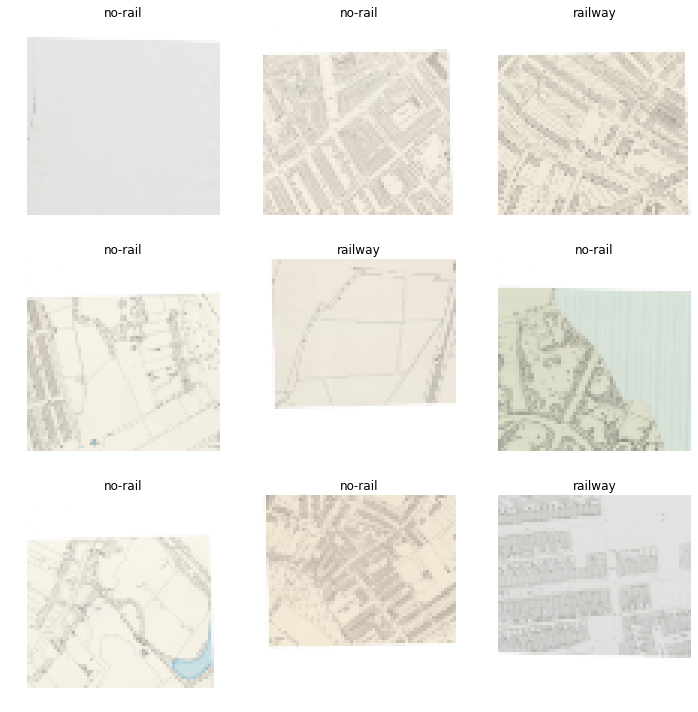

In [36]:
data.show_batch(rows=3, figsize=(10,10))

In [39]:
len(data.train_ds), len(data.valid_ds)

(511, 127)

In [40]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/dvs/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:05<00:00, 15680833.04it/s]


In [41]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.943469,0.676253,0.393701,03:45
1,0.812633,0.718779,0.385827,03:45
2,0.697935,0.695659,0.330709,03:46
3,0.636673,0.710551,0.307087,03:45


# With data augmentation/transforms

In [45]:
tfms = get_transforms(do_flip=True, max_rotate=90, max_zoom=False, max_lighting=None, max_warp=None)

In [46]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train='.', valid_pct=0.2, size=sz, bs=bs, num_workers=4, ds_tfms=tfms).normalize(imagenet_stats)

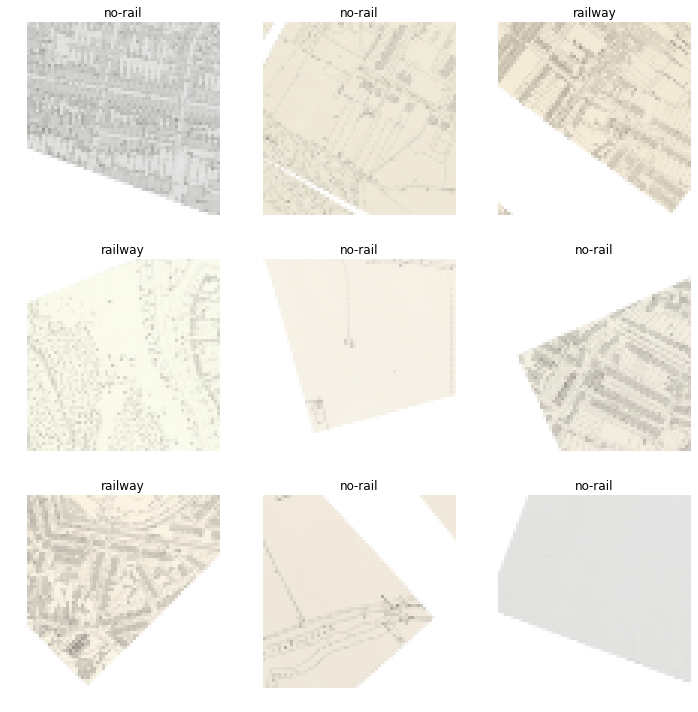

In [47]:
data.show_batch(rows=3, figsize=(10,10))

In [48]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [49]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.938990,0.667127,0.409449,03:45
1,0.895017,0.741133,0.440945,03:47
2,0.869142,0.722251,0.440945,03:47
3,0.854547,0.712034,0.401575,03:47


Higher error rate: suggests transofrms aren't useful 

In [50]:
tfms = get_transforms(do_flip=False, max_rotate=10, max_zoom=False, max_lighting=None, max_warp=None)

In [51]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train='.', valid_pct=0.2, size=sz, bs=bs, num_workers=4, ds_tfms=tfms).normalize(imagenet_stats)

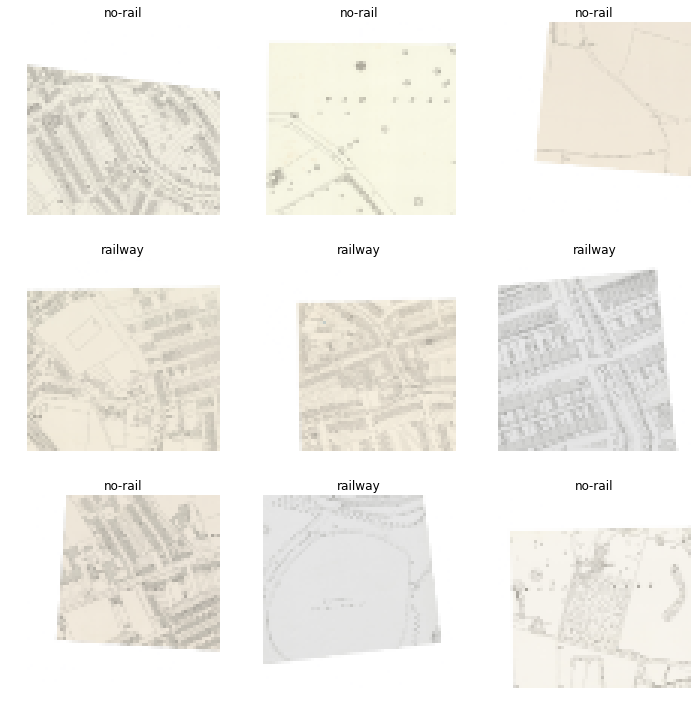

In [52]:
data.show_batch(rows=3, figsize=(10,10))

In [53]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [54]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.924005,0.678369,0.354331,03:47
1,0.837165,0.710611,0.377953,03:46
2,0.820526,0.751164,0.370079,03:48
3,0.781762,0.722560,0.322835,03:48


In [55]:
# With default transforms 

In [59]:
tfms = get_transforms()

In [60]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train='.', valid_pct=0.2, size=sz, bs=bs, num_workers=4, ds_tfms=tfms).normalize(imagenet_stats)

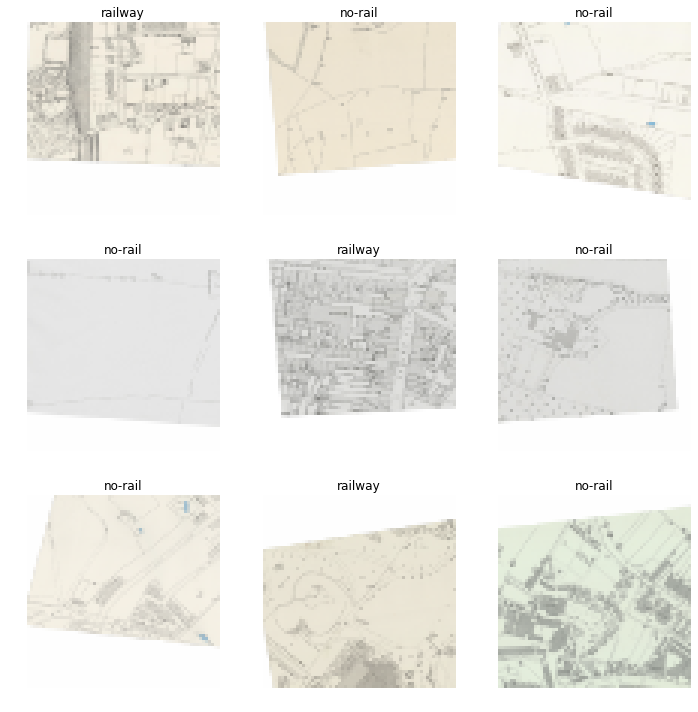

In [61]:
data.show_batch(rows=3, figsize=(10,10))

In [62]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [63]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.974103,0.713292,0.425197,03:46
1,0.953248,0.709114,0.346457,03:47
2,0.937982,0.726407,0.401575,03:50
3,0.912200,0.705668,0.385827,03:50


In [ ]:
# one transform

In [66]:
tfms = get_transforms(do_flip=False, max_rotate=25)

In [67]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train='.', valid_pct=0.2, size=sz, bs=bs, num_workers=4, ds_tfms=tfms).normalize(imagenet_stats)

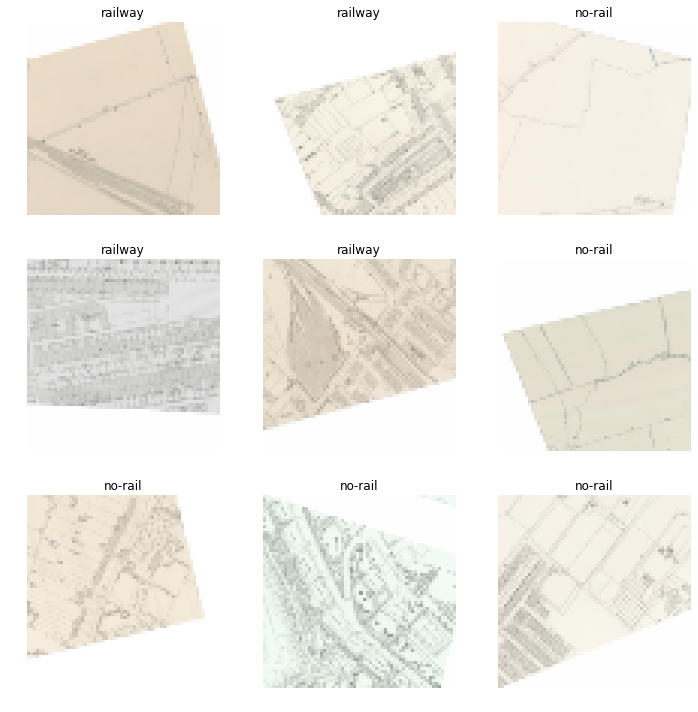

In [68]:
data.show_batch(rows=3, figsize=(10,10))

In [69]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [70]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.860095,0.669402,0.393701,03:45
1,0.838944,0.672551,0.385827,03:46
2,0.809612,0.680132,0.370079,03:46
3,0.814619,0.675781,0.362205,03:45


## Transforms summary 
- so far we didn't get much benefit from the above transforms the final error rate on the model without transforms was better than the error rate for all of the transforms. 
- We shoudn't discount transforms/augmentation of the images just yet but it's likely we will need to create our own since the standard fastai ones are intended for photographs. Since the maps are digitsed in a controlled environment things like warp and lighting are consisent. 
- We only want to do transforms which will be similar to actual training/validation data otherwise we don't help the model learn relevant features. 

# Resnet 50 
Renet50 is a variation on the above model with more layers. It might take slightly longer to train and may benefit from more training data 

In [6]:
data = ImageDataBunch.from_folder(path, train='.', valid_pct=0.2, size=sz, bs=bs, num_workers=4).normalize(imagenet_stats)

In [7]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [8]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.884881,0.760136,0.440945,03:49
1,0.776828,0.789473,0.370079,03:46
2,0.647129,0.949629,0.393701,03:48
3,0.559106,0.887694,0.417323,03:45


In [9]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


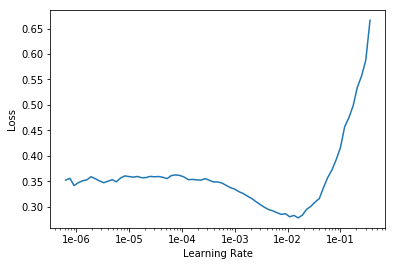

In [10]:
learn.recorder.plot()

# Unfreeze and use new learning rate

In [11]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-04,1e-02))

epoch,train_loss,valid_loss,error_rate,time
0,0.778842,6.934494,0.440945,03:46
1,0.707961,2.258924,0.440945,03:48


In [12]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-06,1e-02))

epoch,train_loss,valid_loss,error_rate,time
0,0.471654,1.595062,0.330709,03:47
1,0.340666,0.963340,0.330709,03:45


In [14]:
learn.save('stage-1-resnet-50')

# Resnet50 with progressive increase in image size 
Starting with a small image size, progressive increase the size of the image being shown to the learner. This is a similar idea to image augentation. We take a small size intially and the model might learn very general features, we then increase the size of image and the model can learn on more detailed images. This can sometimes help with getting a higher model accuracy and allowing the model to ocnverge more quickly. 

In [16]:
# Find orginal image size
from PIL import Image
im = Image.open("data/Maps-railway-training/railway/101200740.27_02_02.jpg")
im.size

(8483, 6223)

In [17]:
# increase size to 128
sz = 128 

In [18]:
data = ImageDataBunch.from_folder(path, train='.', valid_pct=0.2, size=sz, bs=bs, num_workers=4).normalize(imagenet_stats)

In [19]:
learn.load('stage-1-resnet-50')

Learner(data=ImageDataBunch;

Train: LabelList (511 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
no-rail,no-rail,no-rail,no-rail,no-rail
Path: data/Maps-railway-training;

Valid: LabelList (127 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
no-rail,no-rail,no-rail,railway,railway
Path: data/Maps-railway-training;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [20]:
learn.data = data

In [21]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


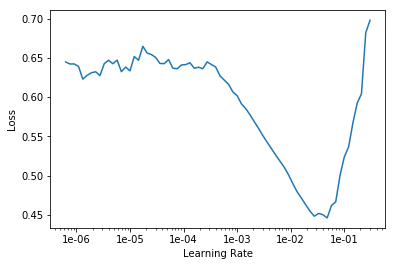

In [22]:
learn.lr_find()
learn.recorder.plot()

In [23]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-03,1e-02))

epoch,train_loss,valid_loss,error_rate,time
0,0.802721,2.794923,0.354331,03:36
1,0.640377,1.962025,0.425197,03:30
2,0.536569,5.547171,0.480315,03:32
3,0.455637,0.849686,0.236220,03:32


In [24]:
learn.save('stage-1-resnet-50-128')

In [25]:
learn.load('stage-1-resnet-50-128');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


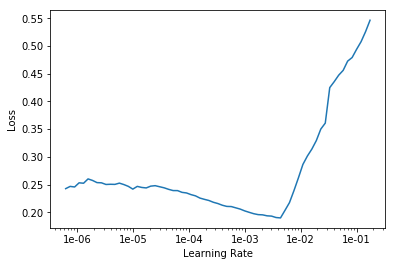

In [26]:
learn.lr_find()
learn.recorder.plot()

In [27]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-05,1e-03))

epoch,train_loss,valid_loss,error_rate,time
0,0.221162,0.576776,0.228346,03:31
1,0.177827,0.563865,0.204724,03:33
2,0.138734,0.594999,0.204724,03:30
3,0.111081,0.601632,0.212598,03:32


In [28]:
learn.save('stage-2-resnet-50-128')

In [8]:
learn.load('stage-2-resnet-50-128');

In [9]:
sz = 526
bs = 32 #need to drop batch size at larger image

In [10]:
data = ImageDataBunch.from_folder(path, train='.', valid_pct=0.2, size=sz, bs=bs, num_workers=4).normalize(imagenet_stats)

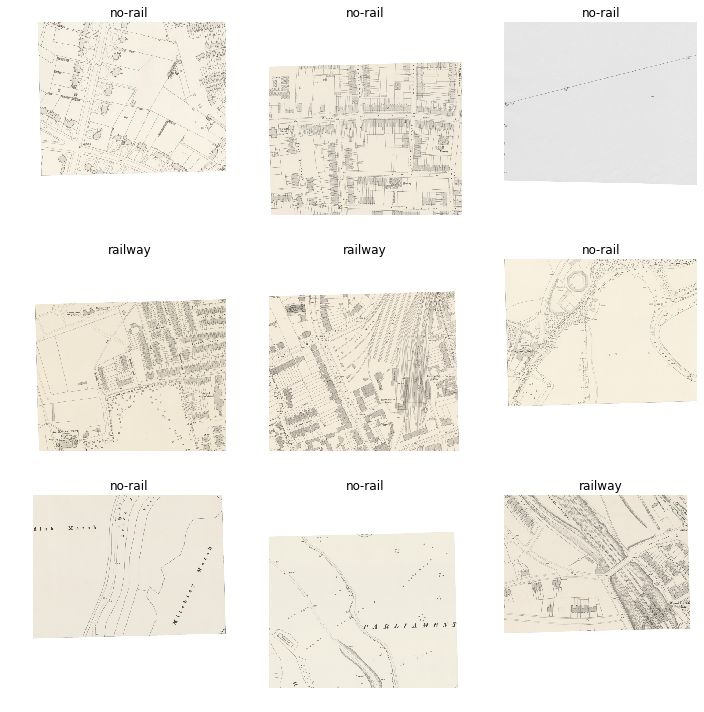

In [12]:
data.show_batch(rows=3, figsize=(10,10))

In [11]:
learn.data = data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


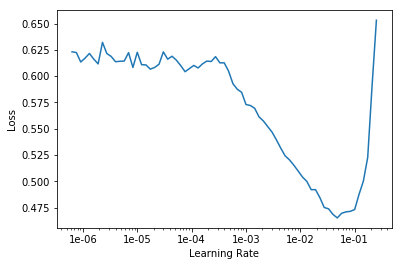

In [11]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [12]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-03,1e-02))

epoch,train_loss,valid_loss,error_rate,time
0,0.582656,3.875337,0.464567,13:21
1,0.512899,135.094452,0.551181,14:21
2,0.436034,0.535989,0.244094,14:40
3,0.364514,0.415170,0.188976,14:37


# Overfitting! 
This model now seems to be overfitting?
valid loss jumped super high...but error rate going down still 

In [35]:
# Un-comment to clear up some GPU memory
# import torch
# torch.cuda.empty_cache()

In [14]:
learn.save('stage-1-resnet-50-526')
learn.load('stage-1-resnet-50-526')

Learner(data=ImageDataBunch;

Train: LabelList (511 items)
x: ImageList
Image (3, 526, 526),Image (3, 526, 526),Image (3, 526, 526),Image (3, 526, 526),Image (3, 526, 526)
y: CategoryList
no-rail,no-rail,no-rail,no-rail,no-rail
Path: data/Maps-railway-training;

Valid: LabelList (127 items)
x: ImageList
Image (3, 526, 526),Image (3, 526, 526),Image (3, 526, 526),Image (3, 526, 526),Image (3, 526, 526)
y: CategoryList
no-rail,railway,no-rail,no-rail,railway
Path: data/Maps-railway-training;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum

# Resnet18 and testing the transfer learning contribution

In [21]:
import torch
torch.cuda.empty_cache()

In [22]:
sz = 64
bs = 64
data = ImageDataBunch.from_folder(path, train='.', valid_pct=0.2, size=sz, bs=bs, num_workers=4).normalize(imagenet_stats)

In [23]:
learn = cnn_learner(data, models.resnet18, metrics=error_rate)

In [24]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.940292,0.692729,0.448819,03:52
1,0.827895,0.721414,0.330709,03:54
2,0.731932,0.745662,0.330709,03:52
3,0.668711,0.690256,0.346457,03:55


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


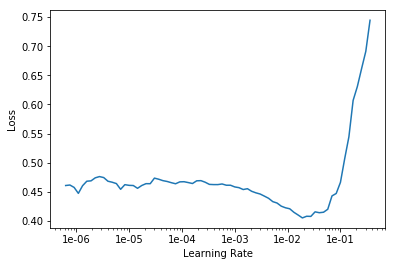

In [25]:
learn.lr_find()
learn.recorder.plot()

In [26]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-03,1e-02))

epoch,train_loss,valid_loss,error_rate,time
0,0.646007,8.477591,0.417323,03:57
1,0.740139,31.290705,0.417323,03:58
2,0.679706,6.059146,0.480315,03:58
3,0.604057,0.866995,0.322835,03:56


In [27]:
learn.save('stage-1-resnet18')

## Does transfer learning work for old maps which don't feature in ImageNet?

ImageNet is pictures of objects in the world - See [examples](http://image-net.org/explore_cloud.php) - does this transfer to old maps when looking for train tracks?

To try and test if transfer learning works lets turn of the pre-trained weights and radomly initalise our resnet model weights and run the same training loop as above. 

In [28]:
# same as above but we remove .normalize(imagenet_stats)
sz = 64
bs = 64
data = ImageDataBunch.from_folder(path, train='.', valid_pct=0.2, size=sz, bs=bs, num_workers=4)

In [29]:
learn = cnn_learner(data, models.resnet18, pretrained=False, metrics=error_rate)

In [30]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.932983,0.694829,0.448819,03:59
1,0.791069,0.716972,0.433071,03:55
2,0.658151,0.845145,0.440945,03:56
3,0.581992,0.802396,0.456693,03:57


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


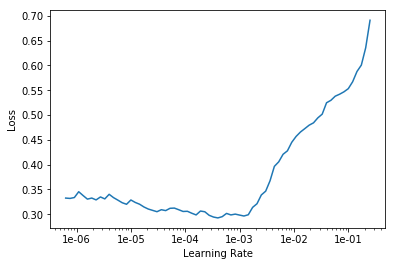

In [31]:
learn.lr_find()
learn.recorder.plot()

In [33]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-05,1e-03/2))

epoch,train_loss,valid_loss,error_rate,time
0,0.311678,0.953686,0.448819,04:00
1,0.261073,0.987611,0.440945,03:59
2,0.214088,1.070632,0.440945,03:57
3,0.177127,1.095498,0.409449,03:58


In [34]:
learn.save('stage-1-resnet18-no-pretraining')

## Initial findings 
A little bit worse starting with pretrained=False. It would be nice to explore further how impact this has for different models, source types and tasks (classifcation vs image localisation etc.) 

# Other models?

TODO: 
- try other models
- try other augmentation 

Further reading: 
- https://medium.com/comet-ml/approach-pre-trained-deep-learning-models-with-caution-9f0ff739010c
- https://miguel-data-sc.github.io/2017-11-23-second/
- http://cs231n.github.io/transfer-learning/
- https://papers.nips.cc/paper/5347-how-transferable-are-features-in-deep-neural-networks.pdf%20/